🔧 Training source encoder + classifier...
Epoch 1 - Source Loss: 2779.5478
Epoch 2 - Source Loss: 2779.3444
Epoch 3 - Source Loss: 2779.3879
Epoch 4 - Source Loss: 2779.3557
Epoch 5 - Source Loss: 2779.3963

🌀 Adversarial training for domain adaptation...
Epoch 1 - Discriminator Loss: 24.4228, Target Encoder Loss: 9012.3714
Epoch 2 - Discriminator Loss: 0.3188, Target Encoder Loss: 13938.0726
Epoch 3 - Discriminator Loss: 0.0748, Target Encoder Loss: 16356.7569
Epoch 4 - Discriminator Loss: 0.0240, Target Encoder Loss: 18305.1249
Epoch 5 - Discriminator Loss: 0.0086, Target Encoder Loss: 20085.4001

📊 Evaluating adapted model on target domain...

🎯 Accuracy on Target Domain: 65.90%


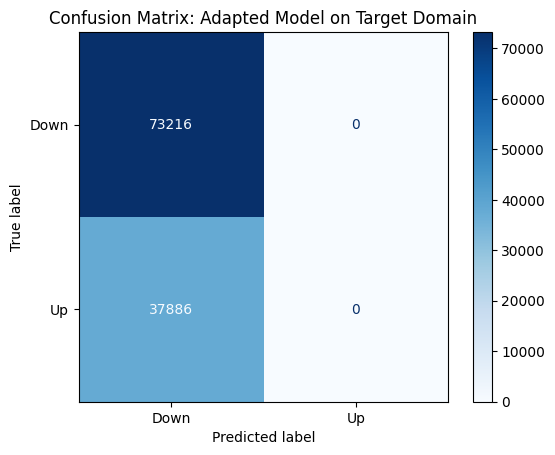

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset

# === 1: Load and preprocess stock data ===
df = pd.read_csv("UNIONBANK__EQ__NSE__NSE__MINUTE.csv")
df = df[['open', 'high', 'low', 'close']].dropna()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def create_sequences(data, seq_len=60, pred_horizon=5):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_horizon):
        X.append(data[i:i+seq_len])
        future_price = data[i+seq_len+pred_horizon][3]
        current_price = data[i+seq_len-1][3]
        label = int(future_price > current_price)
        y.append(label)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

split = int(0.7 * len(X))
X_source, y_source = X[:split], y[:split]
X_target, y_target = X[split:], y[split:]

X_source = torch.tensor(X_source, dtype=torch.float32).permute(0, 2, 1)
y_source = torch.tensor(y_source, dtype=torch.long)
X_target = torch.tensor(X_target, dtype=torch.float32).permute(0, 2, 1)

source_loader = DataLoader(TensorDataset(X_source, y_source), batch_size=64, shuffle=True)
target_loader = DataLoader(TensorDataset(X_target), batch_size=64, shuffle=True)

# === 2: Define Models ===
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=3),
            nn.ReLU(),
            nn.Flatten()
        )
    def forward(self, x):
        return self.feature(x)

class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.classify = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )
    def forward(self, x):
        return self.classify(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.discriminate = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )
    def forward(self, x):
        return self.discriminate(x)

input_dim = 32 * (60 - 2)
source_encoder = Encoder()
target_encoder = Encoder()
classifier = Classifier(input_dim)
discriminator = Discriminator(input_dim)

criterion_cls = nn.CrossEntropyLoss()
criterion_adv = nn.CrossEntropyLoss()

optimizer_se = optim.Adam(source_encoder.parameters(), lr=0.001)
optimizer_clf = optim.Adam(classifier.parameters(), lr=0.001)
optimizer_te = optim.Adam(target_encoder.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# === 3: Train Source Encoder + Classifier ===
print("Training source encoder + classifier...")
for epoch in range(5):
    total_loss = 0
    for data, labels in source_loader:
        optimizer_se.zero_grad()
        optimizer_clf.zero_grad()
        features = source_encoder(data)
        outputs = classifier(features)
        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer_se.step()
        optimizer_clf.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Source Loss: {total_loss:.4f}")

# === 4: Adversarial Training ===
print("\nAdversarial training for domain adaptation...")
for epoch in range(5):
    total_loss_d = 0
    total_loss_te = 0
    for (source_data, _), (target_data,) in zip(source_loader, target_loader):
        optimizer_d.zero_grad()
        source_feat = source_encoder(source_data).detach()
        target_feat = target_encoder(target_data).detach()

        domain_labels = torch.cat([
            torch.zeros(source_feat.size(0), dtype=torch.long),
            torch.ones(target_feat.size(0), dtype=torch.long)
        ])
        domain_preds = discriminator(torch.cat([source_feat, target_feat], dim=0))
        loss_d = criterion_adv(domain_preds, domain_labels)
        loss_d.backward()
        optimizer_d.step()
        total_loss_d += loss_d.item()

        optimizer_te.zero_grad()
        target_feat = target_encoder(target_data)
        domain_preds = discriminator(target_feat)
        fake_labels = torch.zeros(target_feat.size(0), dtype=torch.long)
        loss_te = criterion_adv(domain_preds, fake_labels)
        loss_te.backward()
        optimizer_te.step()
        total_loss_te += loss_te.item()

    print(f"Epoch {epoch+1} - Discriminator Loss: {total_loss_d:.4f}, Target Encoder Loss: {total_loss_te:.4f}")

# === 5: Evaluation ===
print("\nEvaluating adapted model on target domain...")

if len(y_target) > 0:
    target_labels = torch.tensor(y_target, dtype=torch.long)

    target_features = target_encoder(X_target).detach()
    predictions = classifier(target_features).argmax(dim=1)

    acc = accuracy_score(target_labels, predictions)
    cm = confusion_matrix(target_labels, predictions)

    print(f"\nAccuracy on Target Domain: {acc * 100:.2f}%")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix: Adapted Model on Target Domain")
    plt.show()
